# 도착한 LED와 시뮬레이션 vs 실제 실험

### 실험 장치 도면

![장치 도면](dimension.png)

> 노트북과 동일한 폴더의 `dimension.png`를 표시합니다.


한 가운데를 기준으로 할 때, uv 4개, white 4개

uv 1 = [4.43, 1.25]   
uv 2 = [1.55, a]   
uv 3 = - uv1   
uv4 = -uv2

distance between led - illum plane : 6.0 - (0.4 + 0.4 + 2.2) ~= 3.0

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## 1. 빔 방사각 함수 정의 (passivation 효과 반영)
def get_beam_intensity_at_angle(angle_degrees, spread_angle_degrees=0):
    original_angles = np.array([0, 20, 30, 40, 90])
    intensities = np.array([1.0, 0.95, 0.9, 0.8, 0.0])

    adjusted_angles = original_angles + spread_angle_degrees
    adjusted_angles[0] = 0 

    f = interp1d(adjusted_angles, intensities, kind='linear', fill_value="extrapolate")

    if angle_degrees < 0 or angle_degrees > 90 + spread_angle_degrees:
        return 0.0
    return max(0.0, f(angle_degrees).item())

## 2. LED SMD 위치 설정 및 조명 시뮬레이션 함수 (4개 LED로 복원)
def simulate_illumination(target_z_mm=3.00, grid_size_mm=10, resolution=100, spread_angle_degrees=0):
    # led 1
    x_1 = 4.43
    y_1 = 1.25
    # led 2
    x_2 = 1.55
    y_2 = - 5.21 # 4.43 * (45.5/141) from pixel length !!

    led_positions = [
        np.array([x_1, y_1, 0]),     # X축 양의 방향
        np.array([x_2, y_2, 0]),    # X축 음의 방향
        np.array([-x_1, -y_1, 0]),     # Y축 양의 방향
        np.array([-x_2, -y_2, 0])     # Y축 음의 방향
    ]

    x = np.linspace(-grid_size_mm / 2, grid_size_mm / 2, resolution)
    y = np.linspace(-grid_size_mm / 2, grid_size_mm / 2, resolution)
    X, Y = np.meshgrid(x, y)

    illumination_map = np.zeros_like(X)

    for led_pos in led_positions:
        target_points = np.stack([X, Y, np.full_like(X, target_z_mm)], axis=-1)
        vectors = target_points - led_pos
        distances = np.linalg.norm(vectors, axis=-1)
        
        distances = np.where(distances == 0, 1e-9, distances) 

        cos_theta = target_z_mm / distances
        cos_theta = np.clip(cos_theta, 0, 1)

        angle_degrees = np.degrees(np.arccos(cos_theta))
        
        relative_beam_intensity = np.array([get_beam_intensity_at_angle(a, spread_angle_degrees) for a in angle_degrees.flatten()]).reshape(resolution, resolution)
        
        intensity_contribution = relative_beam_intensity * cos_theta / (distances**2)
        illumination_map += intensity_contribution

    return X, Y, illumination_map

## 3. 삼각형으로 잘린 사각형 마스크 생성 함수 (RoundedRectangle 대체) - 현재 사용하지 않음
def create_triangular_cut_mask(X_mesh, Y_mesh, rect_width, rect_height, corner_cut_length):
    """
    주어진 메쉬 그리드에서 삼각형으로 모서리가 잘린 사각형 형태의 불리언 마스크를 생성합니다.
    corner_cut_length: 각 모서리에서 x, y 축을 따라 잘려나갈 길이 (mm).
    """
    mask = np.zeros(X_mesh.shape, dtype=bool)
    
    half_width = rect_width / 2
    half_height = rect_height / 2
    
    # 기본 사각형 영역 (아직 자르기 전)
    basic_square_mask = (np.abs(X_mesh) <= half_width) & (np.abs(Y_mesh) <= half_height)
    
    # 각 모서리 영역을 정의하고 해당 영역을 마스크에서 제외
    # 잘려나가는 선의 기울기가 1이라고 가정 (x+y = const)
    
    # 1사분면 (오른쪽 위) 잘린 영역: (X_mesh - (half_width - corner_cut_length)) + (Y_mesh - (half_height - corner_cut_length)) > corner_cut_length
    cut_mask_q1 = (X_mesh > (half_width - corner_cut_length)) & \
                  (Y_mesh > (half_height - corner_cut_length)) & \
                  ((X_mesh - (half_width - corner_cut_length)) + (Y_mesh - (half_height - corner_cut_length)) > corner_cut_length)

    # 2사분면 (왼쪽 위) 잘린 영역: (-(X_mesh + (half_width - corner_cut_length))) + (Y_mesh - (half_height - corner_cut_length)) > corner_cut_length
    cut_mask_q2 = (X_mesh < -(half_width - corner_cut_length)) & \
                  (Y_mesh > (half_height - corner_cut_length)) & \
                  (-(X_mesh + (half_width - corner_cut_length)) + (Y_mesh - (half_height - corner_cut_length)) > corner_cut_length)

    # 3사분면 (왼쪽 아래) 잘린 영역
    cut_mask_q3 = (X_mesh < -(half_width - corner_cut_length)) & \
                  (Y_mesh < -(half_height - corner_cut_length)) & \
                  (-(X_mesh + (half_width - corner_cut_length)) - (Y_mesh + (half_height - corner_cut_length)) > corner_cut_length) # x, y 모두 음수방향

    # 4사분면 (오른쪽 아래) 잘린 영역
    cut_mask_q4 = (X_mesh > (half_width - corner_cut_length)) & \
                  (Y_mesh < -(half_height - corner_cut_length)) & \
                  ((X_mesh - (half_width - corner_cut_length)) - (Y_mesh + (half_height - corner_cut_length)) > corner_cut_length) # y만 음수방향
    
    # 최종 마스크는 기본 사각형에서 잘린 영역을 제외한 부분
    mask = basic_square_mask & (~cut_mask_q1) & (~cut_mask_q2) & (~cut_mask_q3) & (~cut_mask_q4)
    
    return mask
    
## 4. 균일성(Uniformity) 평가 함수 정의 (마스크 적용)
def evaluate_uniformity(illumination_map, X_mesh, Y_mesh, object_width_mm, object_height_mm, corner_cut_length_mm, center_region_ratio=0.5):
    
    # 삼각형 마스크 대신 간단한 사각형 마스크 사용
    # object_mask = create_triangular_cut_mask(X_mesh, Y_mesh, object_width_mm, object_height_mm, corner_cut_length_mm)
    
    # 간단한 사각형 마스크로 대체
    half_width = object_width_mm / 2
    half_height = object_height_mm / 2
    object_mask = (np.abs(X_mesh) <= half_width) & (np.abs(Y_mesh) <= half_height)
    
    masked_illumination_map = np.where(object_mask, illumination_map, np.nan)

    min_intensity = np.nanmin(masked_illumination_map)
    max_intensity = np.nanmax(masked_illumination_map)
    
    if max_intensity == 0 or np.isnan(max_intensity):
        uniformity_min_max = 0
    else:
        uniformity_min_max = min_intensity / max_intensity
    
    uniformity_std = np.nanstd(masked_illumination_map)

    rows, cols = masked_illumination_map.shape
    
    center_rows_start = int(rows * (0.5 - center_region_ratio / 2))
    center_rows_end = int(rows * (0.5 + center_region_ratio / 2))
    center_cols_start = int(cols * (0.5 - center_region_ratio / 2))
    center_cols_end = int(cols * (0.5 + center_region_ratio / 2))

    center_region = masked_illumination_map[center_rows_start:center_rows_end, center_cols_start:center_cols_end]
    center_intensity_avg = np.nanmean(center_region)

    center_y_index = masked_illumination_map.shape[0] // 2 
    line_data_masked = masked_illumination_map[center_y_index, :] 
    
    valid_line_data = line_data_masked[~np.isnan(line_data_masked)]

    if len(valid_line_data) == 0:
        line_max_val = 0
        line_center_value = 0
        line_center_max_difference = np.inf 
    else:
        line_max_val = np.max(valid_line_data) 
        
        center_x_index_for_line = len(X_mesh[0, :]) // 2 
        line_center_value = line_data_masked[center_x_index_for_line] 

        if np.isnan(line_center_value):
            line_center_value = 0 
        
        line_center_max_difference = line_max_val - line_center_value 

    return uniformity_min_max, uniformity_std, center_intensity_avg, line_center_max_difference, X_mesh[0, :], line_data_masked, object_mask


## 5. 플롯 결과 시각화 함수 (인자 및 통계 계산 방식 변경)
def plot_results(target_z_mm, grid_dimension_mm, simulation_resolution, 
                 object_width_mm, object_height_mm, corner_cut_length_mm, 
                 passivation_spread_angle): # 통계 관련 인자들 제거 (함수 내에서 계산)

    # 이 p_mm_to_plot 값에 대해 시뮬레이션 및 평가를 다시 수행
    X, Y, illumination_full_for_plot = simulate_illumination(
        # p_mm=p_mm_to_plot,
        target_z_mm=target_z_mm,
        grid_size_mm=grid_dimension_mm,
        resolution=simulation_resolution,
        spread_angle_degrees=passivation_spread_angle 
    )
    
    # 해당 p_mm에 대한 균일성 지표들을 다시 계산 (플롯과 출력용)
    uniformity_min_max, uniformity_std, center_intensity_avg, line_center_max_difference, x_coords_line, current_line_data_full, object_mask_for_plot = evaluate_uniformity(
        illumination_full_for_plot, X, Y, object_width_mm, object_height_mm, corner_cut_length_mm
    )

    final_illumination_masked_for_plot = np.where(object_mask_for_plot, illumination_full_for_plot, np.nan)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7)) 

    # 첫 번째 서브플롯: 컬러맵 (마스크된 조명)
    im = axes[0].imshow(final_illumination_masked_for_plot, extent=[X.min(), X.max(), Y.min(), Y.max()], origin='lower', cmap='viridis', vmin=np.nanmin(final_illumination_masked_for_plot) if not np.all(np.isnan(final_illumination_masked_for_plot)) else 0, vmax=np.nanmax(final_illumination_masked_for_plot) if not np.all(np.isnan(final_illumination_masked_for_plot)) else 1)
    fig.colorbar(im, ax=axes[0], label='Illumination Intensity (Arb. Units)')
    axes[0].set_title(f'Illumination Map on Cut-Corner Object (Z = {target_z_mm} mm)\n(Actual LED positions, Spread = {passivation_spread_angle} deg, Cut={corner_cut_length_mm}mm)')
    axes[0].set_xlabel('X (mm)')
    axes[0].set_ylabel('Y (mm)')
    
    # 4개 LED SMD 위치 (점) - simulate_illumination에서 정의한 위치와 동일하게
    x_1 = 4.43
    y_1 = 1.25
    x_2 = 1.55
    y_2 = - 5.21 # 4.43 * (45.5/141) from pixel length
    
    plot_led_x_all = [x_1, x_2, -x_1, -x_2] 
    plot_led_y_all = [y_1, y_2, -y_1, -y_2]
    
    # 모든 LED 위치를 하나의 scatter 호출로 표시
    axes[0].scatter(plot_led_x_all, plot_led_y_all, 
                    color='blue', marker='o', s=100, label='LED Positions (Z=0)') 
    
    # 사각형 윤곽선 그리기 (삼각형 잘린 부분은 표시하지 않음)
    half_width = object_width_mm / 2
    half_height = object_height_mm / 2

    rect_x_coords = [-half_width, half_width, half_width, -half_width, -half_width]
    rect_y_coords = [half_height, half_height, -half_height, -half_height, half_height]

    axes[0].plot(rect_x_coords, rect_y_coords, 'w--', linewidth=2, label=f'Object {object_width_mm}x{object_height_mm}mm')
    
    # 추가 요청: 중심 원점의 4.44x2.5mm 흰색 점선 사각형 (Aperture)
    square_4_44_width = 10 # 가로 길이
    square_2_5_height = 10 # 세로 길이
    square_4_44_half_width = square_4_44_width / 2
    square_2_5_half_height = square_2_5_height / 2
    
    square_4_44_x = [-square_4_44_half_width, square_4_44_half_width, square_4_44_half_width, -square_4_44_half_width, -square_4_44_half_width]
    square_4_44_y = [square_2_5_half_height, square_2_5_half_height, -square_2_5_half_height, -square_2_5_half_height, square_2_5_half_height]
    axes[0].plot(square_4_44_x, square_4_44_y, 'w:', linewidth=2, label='object 10x10mm')

    # 추가 요청: 중심 원점의 7.55mm 빨간색 실선 정사각형 (LED Array Area)
    square_4_88_half = 7.55 / 2
    square_4_88_x = [-square_4_88_half, square_4_88_half, square_4_88_half, -square_4_88_half, -square_4_88_half]
    square_4_88_y = [square_4_88_half, square_4_88_half, -square_4_88_half, -square_4_88_half, square_4_88_half]
    axes[0].plot(square_4_88_x, square_4_88_y, 'r-', linewidth=1, label='LED Array Area 7.55x7.55mm') 

    # 추가 요청: 각 LED SMD 위치를 중심으로 하는 칩 크기 사각형 (X, Y축 LED 크기 다르게)
    # X축 LED 칩 크기 (가로: 2.3mm, 세로: 1.0mm)
    smd_x_width = 2.30
    smd_x_height = 1.0

    # Y축 LED 칩 크기 (가로: 1.0mm, 세로: 2.30mm)
    smd_y_width = 1.0
    smd_y_height = 2.30
    
    # 통합된 범례 라벨
    overall_smd_label_set = False # 첫 번째 LED에만 라벨을 붙이기 위한 플래그

    # 모든 4개 LED 위치에 대해 루프를 돌며 칩 크기 사각형 플롯
    for i in range(len(plot_led_x_all)): 
        led_x = plot_led_x_all[i]
        led_y = plot_led_y_all[i]
        
        # LED 위치에 따라 사용할 칩 크기 및 색상 선택
        if i == 1 or i == 3: # 첫 번째와 세 번째 LED (x_1, -x_1 위치)
            current_smd_width = smd_x_width
            current_smd_height = smd_x_height
            current_smd_color = 'b-'
            label_prefix = 'X-axis'
        else: # 두 번째와 네 번째 LED (x_2, -x_2 위치)
            current_smd_width = smd_y_width
            current_smd_height = smd_y_height
            current_smd_color = 'b-'
            label_prefix = 'Y-axis'
        
        smd_half_width = current_smd_width / 2
        smd_half_height = current_smd_height / 2

        smd_rect_x = [led_x - smd_half_width, led_x + smd_half_width, led_x + smd_half_width, led_x - smd_half_width, led_x - smd_half_width]
        smd_rect_y = [led_y + smd_half_height, led_y + smd_half_height, led_y - smd_half_height, led_y - smd_half_height, led_y + smd_half_height]
        
        # 첫 번째 LED 칩 사각형에만 통합 라벨을 붙임
        if not overall_smd_label_set:
            label_text = f'LED SMD Chip {smd_x_width}x{smd_x_height}mm'
            overall_smd_label_set = True
        else:
            label_text = None
            
        axes[0].plot(smd_rect_x, smd_rect_y, current_smd_color, linewidth=1, label=label_text)

    # 레전드 위치 수정: 우측 최상단으로 이동
    axes[0].legend(loc='upper right') 
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # 두 번째 서브플롯: y=0 라인 플롯 (마스크된 데이터 사용)
    valid_line_mask = ~np.isnan(current_line_data_full) # 함수 내에서 계산된 current_line_data_full 사용
    axes[1].plot(x_coords_line[valid_line_mask], current_line_data_full[valid_line_mask], color='blue', linewidth=2)
    axes[1].set_title(f'Illumination Line Plot at Z={target_z_mm} mm, Y=0 (on Cut-Corner Object)')
    axes[1].set_xlabel('X (mm)')
    axes[1].set_ylabel('Illumination Intensity')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    
    if len(current_line_data_full[valid_line_mask]) > 0:
        axes[1].axhline(y=np.nanmin(current_line_data_full), color='r', linestyle=':', label='Min Intensity')
        axes[1].axhline(y=np.nanmax(current_line_data_full), color='g', linestyle=':', label='Max Intensity')
    
    center_x_index_for_line = len(x_coords_line) // 2
    line_center_x_val = x_coords_line[center_x_index_for_line]
    line_center_y_val = current_line_data_full[center_x_index_for_line] # 함수 내에서 계산된 값
    
    if not np.isnan(line_center_y_val):
        axes[1].plot(line_center_x_val, line_center_y_val, 'ko', markersize=8, label='Center (X=0)') 
    
    # 레전드 위치 수정: 우측 최상단으로 이동
    axes[1].legend(loc='upper right') 

    plt.tight_layout()
    plt.show()

    # 통계 출력 (함수 인자로 전달받은 best_xxx_ 값을 사용)
    print("\n--- Illumination Statistics for Selected p_mm (Cut-Corner Object) ---")
    # plot_results 함수가 인자로 받은 통계치 변수를 직접 사용
    if not np.all(np.isnan(final_illumination_masked_for_plot)): # nanmin/nanmax가 NaN을 반환할 수 있으므로 다시 확인
        print(f"최대 조명 강도: {np.nanmax(final_illumination_masked_for_plot):.4f}")
        print(f"최소 조명 강도: {np.nanmin(final_illumination_masked_for_plot):.4f}")
        print(f"평균 조명 강도: {np.nanmean(final_illumination_masked_for_plot):.4f}")
        print(f"조명 강도 표준 편차: {np.nanstd(final_illumination_masked_for_plot):.4f}")
        if np.nanmax(final_illumination_masked_for_plot) > 0:
            print(f"균일성 (min/max): {uniformity_min_max:.4f}") # 함수 내부에서 계산된 값 사용
        else:
            print("균일성 (min/max): N/A (Max intensity is zero or NaN)")
    else:
        print("객체 영역에 유효한 조명 데이터가 없습니다.")


    print("\n--- Line Plot Statistics for Selected p_mm (Y=0, on Cut-Corner Object) ---")
    valid_line_data_for_stats = current_line_data_full[~np.isnan(current_line_data_full)] # 함수 내에서 계산된 current_line_data_full 사용
    if len(valid_line_data_for_stats) > 0:
        print(f"라인 플롯 최대값: {np.max(valid_line_data_for_stats):.4f}") 
        print(f"라인 플롯 최소값: {np.min(valid_line_data_for_stats):.4f}") 
        print(f"라인 플롯 중점(X=0)에서의 값: {current_line_data_full[len(x_coords_line)//2]:.4f}") 
        print(f"라인 플롯 중점-최댓값 차이 (Center-Max Difference): {line_center_max_difference:.4f}") # 함수 내부에서 계산된 값 사용
    else:
        print("라인 플롯 데이터 없음 (객체 영역 밖)")


## 6. 최적화 실행 함수
def run_optimization(p_mm_min_val, p_mm_max_val, p_mm_step_val, 
                     target_z_mm, grid_dimension_mm, simulation_resolution, 
                     object_width_mm, object_height_mm, corner_cut_length_mm, 
                     passivation_spread_angle, max_no_improvement_tolerence): 

    best_p_mm = None
    best_uniformity_score = -np.inf 
    # 최적화 결과 저장용 변수들
    best_min_max_ratio = 0
    best_std_dev = np.inf
    best_center_intensity = 0
    best_line_center_max_difference = np.inf
    best_x_coords_line = None
    best_line_data = None
    best_object_mask = None

    no_improvement_count = 0
    
    whose_best_line_diff = None 
    best_line_center_max_difference_overall = np.inf

    print(f"Searching for optimal p_mm between {p_mm_min_val:.2f}mm and {p_mm_max_val:.2f}mm with step {p_mm_step_val:.2f}mm...")
    print(f"Simulation grid size: {grid_dimension_mm}mm x {grid_dimension_mm}mm")
    print(f"Target object: Triangular-cut rectangle ({object_width_mm}x{object_height_mm}mm, Cut={corner_cut_length_mm}mm)")
    print(f"Passivation spread angle applied: {passivation_spread_angle} degrees")
    print(f"Optimization will stop if score does not improve for {max_no_improvement_tolerence} consecutive steps.")

    for p in np.arange(p_mm_min_val, p_mm_max_val + p_mm_step_val, p_mm_step_val):
        X, Y, illumination = simulate_illumination(
            p_mm=p,
            target_z_mm=target_z_mm,
            grid_size_mm=grid_dimension_mm,
            resolution=simulation_resolution,
            spread_angle_degrees=passivation_spread_angle
        )

        uniformity_min_max, uniformity_std, center_intensity_avg, line_center_max_difference, x_coords_line, current_line_data_full, current_object_mask = evaluate_uniformity(
            illumination, X, Y, object_width_mm, object_height_mm, corner_cut_length_mm
        )
        
        if line_center_max_difference < best_line_center_max_difference_overall:
            best_line_center_max_difference_overall = line_center_max_difference
            whose_best_line_diff = p

        current_uniformity_score = (uniformity_min_max * 1500) \
                                 - (uniformity_std * 500) \
                                 - (line_center_max_difference * 10000) \
                                 + (center_intensity_avg * 1)
        
        print(f"p={p:.2f}mm: Min/Max={uniformity_min_max:.4f}, Std={uniformity_std:.4f}, Center Avg={center_intensity_avg:.4f}, Line Center-Max Diff={line_center_max_difference:.4f}, Score={current_uniformity_score:.4f}")

        if current_uniformity_score > best_uniformity_score:
            best_uniformity_score = current_uniformity_score
            best_p_mm = p
            best_min_max_ratio = uniformity_min_max
            best_std_dev = uniformity_std
            best_center_intensity = center_intensity_avg
            best_line_center_max_difference = line_center_max_difference 
            best_x_coords_line = x_coords_line
            best_line_data = current_line_data_full 
            best_object_mask = current_object_mask
            no_improvement_count = 0 
        else:
            no_improvement_count += 1 
            print(f"No improvement for {no_improvement_count} steps.")
            if no_improvement_count >= max_no_improvement_tolerence:
                print(f"Stopping optimization: No improvement for {max_no_improvement_tolerence} consecutive steps.")
                break 
            
    print("\n--- Optimization Results ---")
    if best_p_mm is not None:
        print(f"Optimal p_mm found (based on composite score): {best_p_mm:.2f} mm")
        print(f"Best Min/Max Ratio: {best_min_max_ratio:.4f}")
        print(f"Best Standard Deviation: {best_std_dev:.4f}")
        print(f"Best Center Intensity Avg: {best_center_intensity:.4f}")
        print(f"Best Line Center-Max Difference (from composite score): {best_line_center_max_difference:.4f}") 
        print(f"Best Composite Uniformity Score: {best_uniformity_score:.4f}")
        print(f"\nSmallest Line Center-Max Difference found at p = {whose_best_line_diff:.2f} mm (value: {best_line_center_max_difference_overall:.4f})") 
        
        # 최적화된 파라미터와 결과 데이터 반환
        return {
            'best_p_mm': best_p_mm,
            'best_min_max_ratio': best_min_max_ratio,
            'best_std_dev': best_std_dev,
            'best_center_intensity': best_center_intensity,
            'best_line_center_max_difference': best_line_center_max_difference,
            'best_uniformity_score': best_uniformity_score,
            'best_x_coords_line': best_x_coords_line,
            'best_line_data': best_line_data,
            'best_object_mask': best_object_mask,
            'whose_best_line_diff': whose_best_line_diff,
            'best_line_center_max_difference_overall': best_line_center_max_difference_overall
        }
    else:
        print("No optimal p_mm found in the given range.")
        return None


--- Custom Plot for z = 4.0mm ---


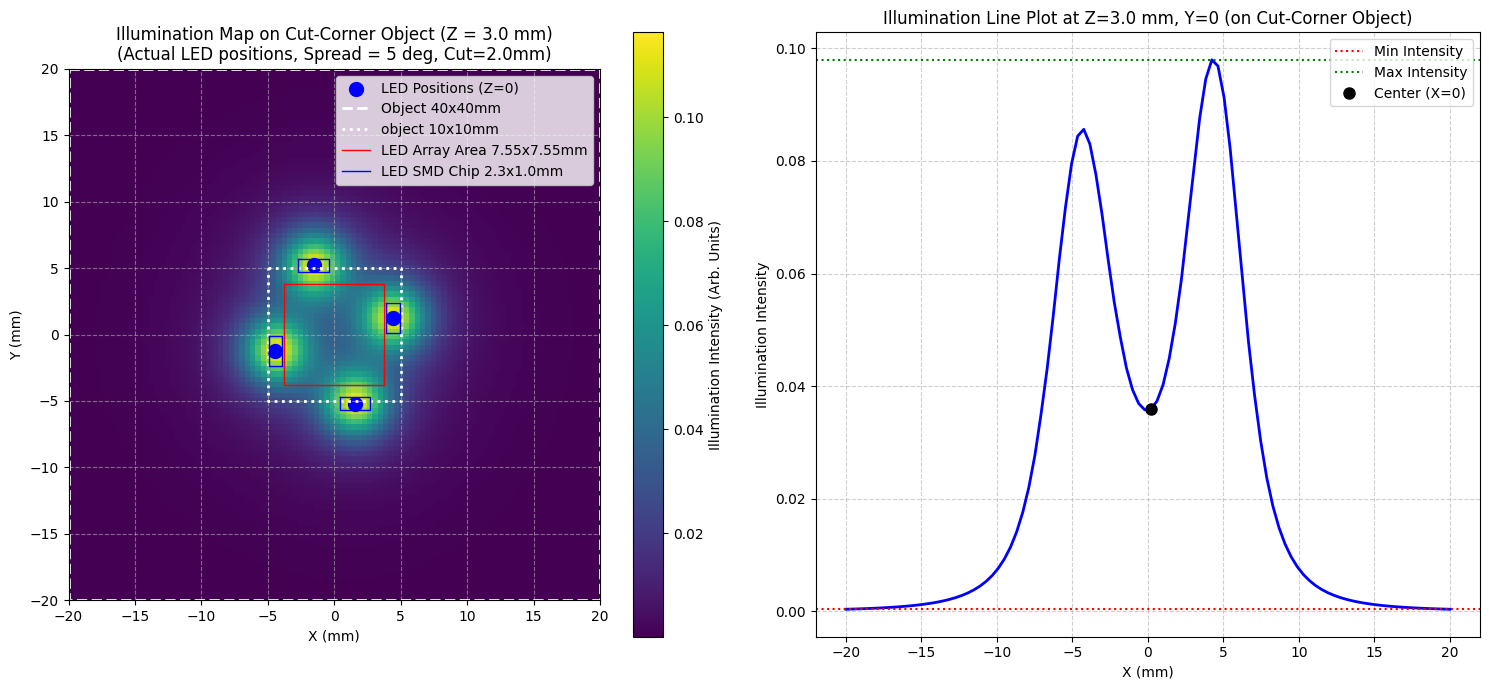


--- Illumination Statistics for Selected p_mm (Cut-Corner Object) ---
최대 조명 강도: 0.1163
최소 조명 강도: 0.0001
평균 조명 강도: 0.0084
조명 강도 표준 편차: 0.0188
균일성 (min/max): 0.0009

--- Line Plot Statistics for Selected p_mm (Y=0, on Cut-Corner Object) ---
라인 플롯 최대값: 0.0980
라인 플롯 최소값: 0.0004
라인 플롯 중점(X=0)에서의 값: 0.0359
라인 플롯 중점-최댓값 차이 (Center-Max Difference): 0.0621


In [21]:

## 메인 실행 블록 (주피터 노트북에서 각 함수를 호출하여 사용)
if __name__ == "__main__":
    # 고정된 파라미터 (최적화 및 플롯에 공통으로 사용될 값)
    common_params = {
        'target_z_mm': 3.00,
        'grid_dimension_mm':40.0, # 측정
        'simulation_resolution': 100, # 최적화 시 100, 최종 플롯 시 200 등으로 변경 가능
        'object_width_mm': 40,
        'object_height_mm': 40,
        'corner_cut_length_mm': 2.0,
        'passivation_spread_angle': 5
    }

    # # 최적화 파라미터 (p_mm) 설정
    # optimization_params = {
    #     'p_mm_min_val': 2.7 + 1.62/2,
    #     'p_mm_max_val': 5.5 - 1.62/2,
    #     'p_mm_step_val': 0.1,
    #     'max_no_improvement_tolerence': 2 # 조기 종료 횟수
    # }

    # print("Running optimization...")
    # optimized_results = run_optimization(
    #     **optimization_params,
    #     **common_params # common_params에 있는 모든 키-값 쌍을 인자로 전달
    # )

    # if optimized_results:
    #     print("\n--- Final Visualization for Optimal p_mm ---")
    #     plot_results(
    #         p_mm_to_plot=optimized_results['best_p_mm'],
    #         target_z_mm=common_params['target_z_mm'],
    #         grid_dimension_mm=common_params['grid_dimension_mm'],
    #         simulation_resolution=common_params['simulation_resolution'],
    #         object_width_mm=common_params['object_width_mm'],
    #         object_height_mm=common_params['object_height_mm'],
    #         corner_cut_length_mm=common_params['corner_cut_length_mm'],
    #         passivation_spread_angle=common_params['passivation_spread_angle']
    #     )

    # 주피터 노트북에서 개별적으로 호출하여 플롯을 확인하는 예시
    # 예를 들어, p=4.0mm 일 때의 플롯을 보고 싶다면:
    print("\n--- Custom Plot for z = 4.0mm ---")
    plot_results(
        # p_mm_to_plot=4.0,
        target_z_mm=common_params['target_z_mm'],
        grid_dimension_mm=common_params['grid_dimension_mm'],
        simulation_resolution=common_params['simulation_resolution'],
        object_width_mm=common_params['object_width_mm'],
        object_height_mm=common_params['object_height_mm'],
        corner_cut_length_mm=common_params['corner_cut_length_mm'],
        passivation_spread_angle=common_params['passivation_spread_angle']
    )